# Quantum Fourier Iterative Amplitude Estimation

Code at: [https://github.com/qiboteam/qibo/tree/master/examples/qfiae](https://github.com/qiboteam/qibo/tree/master/examples/qfiae).

Based in the paper [arXiv:2305.01686](https://arxiv.org/abs/2305.01686)

## Problem overview
This tutorial implements an example of the application of the Quantum Fourier Iterative Amplitude Estimation (QFIAE) method, which allows to perform Quantum Monte Carlo integration of any one-dimensional function $f(x)$. 

The QFIAE algorithm functioning is the following:

 1. The function we want to integrate $f(x)$, the probability distribution $p(x)$ and the limits of the integral $x_{min}$, $x_{max}$ are defined

 2. A Quantum Neural Network (QNN) is employed to fit the function $f(x)$ using a linear ansatz of the following form:
 ![linear_ansatz](images/linear_ansatz.jpg)
 where $\mathcal{L}^{(i)}$ is the i-th layer, that for the one-dimensional case is composed of the trainable gates:
 $$ \mathcal{A}^{(i)}=R_z(\theta_{i,2})R_z(\theta_{i,1})R_z(\theta_{i,0}),$$
 and the encoding gate:
  $$ \mathcal{S}=R_z(x).$$
 
 Now, as demonstrated in [arXiv:2008.08605](https://arxiv.org/abs/2008.08605) the expectation value of this quantum model corresponds to a universal 1-D Fourier series:
 $$\langle \textit{M} \rangle (x, {\vec{\theta}}) = \sum_{w \in \Omega} c_w e^{ixw}~.$$

 3. The Fourier coefficients of the quantum circuit that fits the function $f(x)$ are extracted using [discrete Fourier transform](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html)
 
 4. The Iterative Quantum Amplitude Estimation (IQAE) model of qibo, which corresponds with the following quantum circuit:
 ![iqae](images/iqae.png)
 is used to estimate the integral of each trigonometric piece, $\sin(\omega_i x)$ or $\cos(\omega_j x)$, of the Fourier series.
 
 5. The integrals obtained are summed with their corresponding coefficients to derive the final integral result.


A summary of the workflow of the algorithm is the following:
![workflow](images/sketch_qfiae.png)



## QFIAE Demo

Let's define the problem:

We are interested in computing the following example integral:
$$ \int_0^1 dx(1+x^2),$$
so the easiest way to define our problem variables would be:

 - $x_{min}$: $0$
 
 - $x_{max}$: $1$
 
 - $p(x)$: $dx$
 
 - $f(x)$: $1+x^2$

## Code

First, we must decide the variables for our problem. 

Regarding the definition of the problem:

- `x_min_int`: the lower limit of the problem integral.

- `x_max_int`: the upper limit of the problem integral.

Regarding the QNN:

- `number_of_layers`: number of layers of the QNN.

- `number_of_epochs`: number of epochs, i.e. iterations of the AdamDescent Optimizer.

- `loss_treshold`: value of the desired loss function's treshold.

- `learning_rate`: learning rate of the AdamDescent Optimizer.

- `number_of_batches`: number of batches in which divide the dataset.

- `number_of_data_points`: number of data points to define $f(x)$.

- `x_max_fit`: upper limit of the function we are going to fit. 

- `x_min_fit`: lower limit of the function we are going to fit. 

Regarding the IQAE

- `n_qubits`: number of qubits decided to build the good state in the IQAE algorithm.

- `alpha`: confidence level, the target probability is 1 - `alpha`, has values between 0 and 1.

- `epsilon`: target precision for estimation target $a$, has values between 0 and 0.5.

- `n_shots`: number of shots used to perform IQAE. 

- `method_iqae`: statistical method employed by IQAE. It will be *chernoff* or *beta*. 

Include necessary packages:

In [1]:
import numpy as np

from qibo import gates
from qibo.models import Circuit
from qibo.models.iqae import IQAE

### 1. Defining $f(x)$, $x_{min}$, $x_{max}$

In [2]:
def f(x): 
    """Target function f(x) = 1 + x ^ 2"""
    
    y = 1 + x ** 2
    return y

x_min_int = 0
x_max_int = 1

### 2. Defining and training the QNN

We import the QNN: `vqregressor_linear_ansatz`, which is a modified version of the vqregressor found at https://github.com/qiboteam/qibo/tree/master/examples/vqregressor. In our modified version, we replace the ansatz function used in the original implementation with the one we have previously defined.

In [3]:
from vqregressor_linear_ansatz import VQRegressor_linear_ansatz

We define the parameters of the QNN

In [4]:
number_of_layers = 10
number_of_epochs = 100
loss_treshold = 10^-4
learning_rate = 0.05
number_of_batches = 1
number_of_data_points = 200
# Note they can be different than x_min,x_max, but [x_max,x_min] ⊆ [x_max_fit,x_min_fit] 
x_max_fit = 1
x_min_fit = -1

[Qibo 0.1.15|INFO|2023-06-19 09:50:18]: Using qibojit (numba) backend on /CPU:0


Iteration  1  epoch  1  | loss:  0.27956097409781455
Iteration  2  epoch  2  | loss:  0.13455265155380589
Iteration  3  epoch  3  | loss:  0.04929675984002434
Iteration  4  epoch  4  | loss:  0.03257498942228556
Iteration  5  epoch  5  | loss:  0.04255687556008098
Iteration  6  epoch  6  | loss:  0.04675919417131338
Iteration  7  epoch  7  | loss:  0.04057951780879927
Iteration  8  epoch  8  | loss:  0.030865194118456646
Iteration  9  epoch  9  | loss:  0.02713312406365499
Iteration  10  epoch  10  | loss:  0.0326079895430221
Iteration  11  epoch  11  | loss:  0.038614304614788826
Iteration  12  epoch  12  | loss:  0.037142928519652105
Iteration  13  epoch  13  | loss:  0.030434270849048314
Iteration  14  epoch  14  | loss:  0.02472084821677015
Iteration  15  epoch  15  | loss:  0.022727822727538795
Iteration  16  epoch  16  | loss:  0.022518094787308204
Iteration  17  epoch  17  | loss:  0.021297100510650976
Iteration  18  epoch  18  | loss:  0.01838404246272138
Iteration  19  epoch  

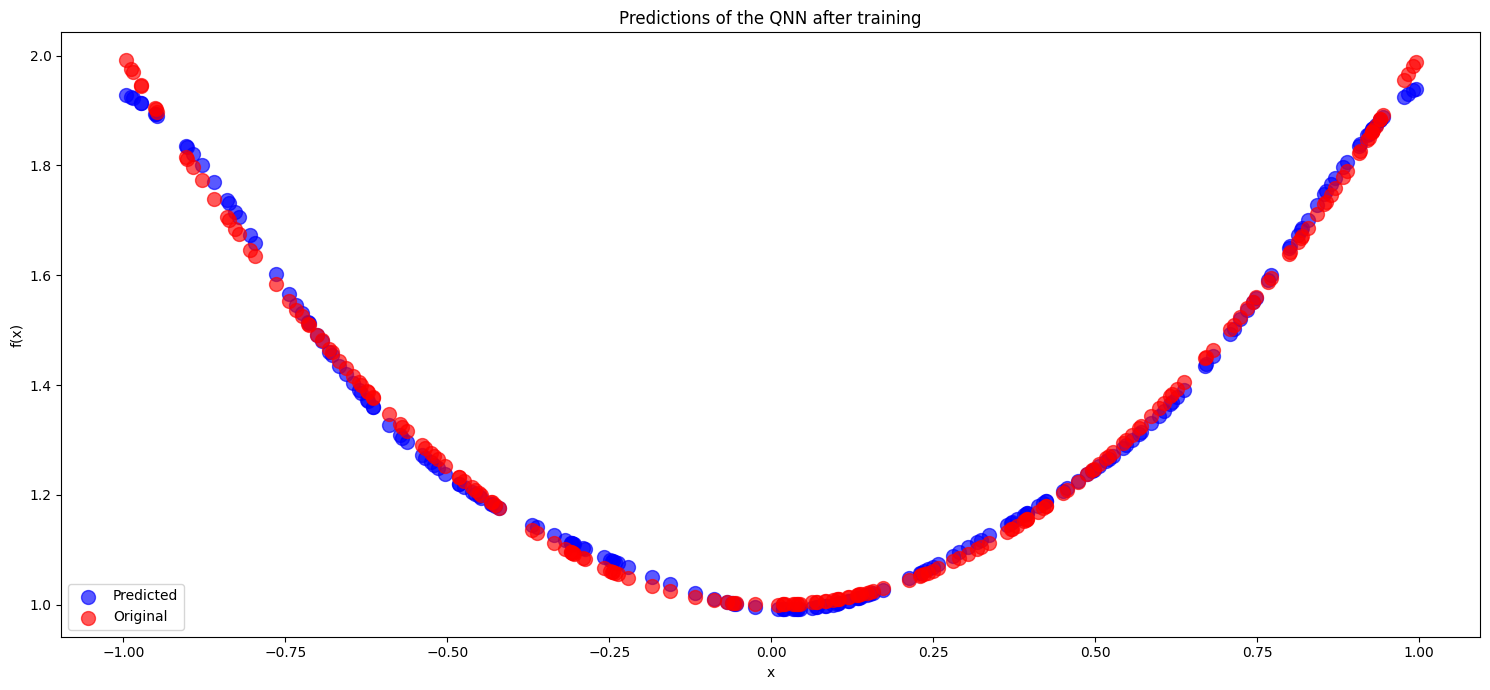

In [5]:
vqr = VQRegressor_linear_ansatz(layers=number_of_layers, 
                                ndata=number_of_data_points,
                                function=f, xmax=x_max_fit, 
                                xmin=x_min_fit)
vqr.train_with_psr(
    epochs=number_of_epochs,
    learning_rate=learning_rate,
    batches=number_of_batches,
    J_treshold=loss_treshold,
)
vqr.show_predictions("Predictions of the QNN after training", False)

### 3. Obtaining the Fourier series from the QNN

In [6]:
# We import the qibo function that obtains the Fourier series out of a 
# quantum circuit that returns an expectation value
from qibo.models.utils import fourier_coefficients
# We get the optimized quantum circuit and the normalized Fourier coefficients
quantum_circuit_optimized = vqr.one_prediction
normalized_coeffs = fourier_coefficients(quantum_circuit_optimized,
                              n_inputs=1, degree=number_of_layers, lowpass_filter=True)
# We obtain the non-normalized coeffs
coeffs = normalized_coeffs * vqr.norm

Let's see how they look like

In [7]:
print(coeffs)

[ 8.21705260e-01+0.j          4.39941976e-01+0.08313535j
 -2.60541764e-01-0.23403475j -5.44645033e-02+0.28760091j
 -1.21655232e-01-0.12307206j  7.06872983e-02-0.09017757j
  9.81551839e-03+0.15075766j  5.68660207e-02-0.07986668j
 -5.78643550e-02+0.01002008j  2.26845268e-03+0.00929322j
  3.63161955e-04-0.00044398j  3.63161955e-04+0.00044398j
  2.26845268e-03-0.00929322j -5.78643550e-02-0.01002008j
  5.68660207e-02+0.07986668j  9.81551839e-03-0.15075766j
  7.06872983e-02+0.09017757j -1.21655232e-01+0.12307206j
 -5.44645033e-02-0.28760091j -2.60541764e-01+0.23403475j
  4.39941976e-01-0.08313535j]


Now we check that Fourier series obtained it's correct and also fits the function 

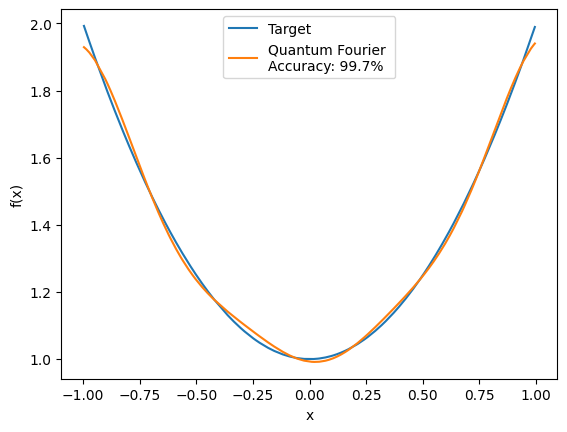

In [8]:
# We import some functions to obtain the Fourier series from the coefficients and to plot these results
from utils_qfiae import fourier_series, plot_data_fourier
# We plot the original function and the Fourier approximation
y_fourier = fourier_series(coeffs, vqr.features)
plot_fourier, accuracy_qnn = plot_data_fourier(vqr.labels * vqr.norm, vqr.features, y_fourier)
quantum_fourier_error_percent = 100 - accuracy_qnn

### 4. Integrating every trigonometric piece

First we should rewrite the Fourier coefficients in a way that will be easy to integrate the trigonometric functions Sine and Cosine

In [9]:
# We import some functions to convert exponential-like Fourier coefficients into trigonometric-like and to
# convert this trigonometric coeffs into an array that provides insight about if we get a Sine or a Cosine
from utils_qfiae import exp_fourier_to_trig, trig_to_final_array
trig_coeffs = exp_fourier_to_trig(coeffs)
fourier_array = trig_to_final_array(trig_coeffs)

Let's visualize what we have and note that 0 stands for Cosine and 1 stands for Sine

In [10]:
print(fourier_array)

[[ 0.00000000e+00  0.00000000e+00  8.21705260e-01]
 [ 0.00000000e+00  1.00000000e+00  8.79883952e-01]
 [ 0.00000000e+00  2.00000000e+00 -5.21083528e-01]
 [ 0.00000000e+00  3.00000000e+00 -1.08929007e-01]
 [ 0.00000000e+00  4.00000000e+00 -2.43310463e-01]
 [ 0.00000000e+00  5.00000000e+00  1.41374597e-01]
 [ 0.00000000e+00  6.00000000e+00  1.96310368e-02]
 [ 0.00000000e+00  7.00000000e+00  1.13732041e-01]
 [ 0.00000000e+00  8.00000000e+00 -1.15728710e-01]
 [ 0.00000000e+00  9.00000000e+00  4.53690536e-03]
 [ 0.00000000e+00  1.00000000e+01  7.26323909e-04]
 [ 1.00000000e+00  1.00000000e+00 -1.66270703e-01]
 [ 1.00000000e+00  2.00000000e+00  4.68069493e-01]
 [ 1.00000000e+00  3.00000000e+00 -5.75201826e-01]
 [ 1.00000000e+00  4.00000000e+00  2.46144119e-01]
 [ 1.00000000e+00  5.00000000e+00  1.80355137e-01]
 [ 1.00000000e+00  6.00000000e+00 -3.01515323e-01]
 [ 1.00000000e+00  7.00000000e+00  1.59733368e-01]
 [ 1.00000000e+00  8.00000000e+00 -2.00401617e-02]
 [ 1.00000000e+00  9.00000000e+

Before implementeing the IQAE model, we should define the quantum circuits $\mathcal{A}$ and $\mathcal{Q}$.

The circuit $\mathcal{A}$ is defined as:
$$|\psi\rangle=\mathcal{A}|0\rangle_{n+1}=\sqrt{a}|\tilde{\psi}_1\rangle|1\rangle +\sqrt{1-a}|\tilde{\psi}_0\rangle|0\rangle,$$
where $a\in[0,1]$ is the parameter to be estimated, while $|\tilde{\psi}_1\rangle$ and $|\tilde{\psi}_0\rangle$ are the $n$-qubit good and bad states, respectively.

From a more practical point of view, this circuit can be decomposed in two pieces:
$$\mathcal{A}=\left(\mathcal{P}\otimes \mathcal{I}_1\right)\mathcal{R},$$
where $\mathcal{I}_1$ is the identity matrix acting over the last qubit.

So, to get $\mathcal{A}$ we have to define the operator $\mathcal{P}$, which encodes the probability distribution $p(x)$, and the operator $\mathcal{R}$, which encodes the function we are going to integrate, $\sin(x)^2$, into the interval $[b_{min},b_{max}]$

In [11]:
def operator_p(circ, list_of_qubits):
    """Generating the uniform probability distribution p(x)=1/2^n"""
    
    for qubit in list_of_qubits:
        circ.add(gates.H(q=qubit))

def operator_r(circ, list_of_qubits, qubit_to_measure, b_max, b_min):
    """Encoding the function Sin(x)^2 to be integrated in the interval [b_min,b_max]"""
    
    number_of_qubits = qubit_to_measure
    circ.add(
        gates.RY(q=qubit_to_measure, theta=(b_max - b_min) / 2 ** number_of_qubits + 2 * b_min)
    )
    for qubit in list_of_qubits:
        circ.add(
            gates.CU3(qubit, qubit_to_measure, 
                      2 ** (qubit + 1) * (b_max - b_min) / 2 ** number_of_qubits , 0, 0)
        )

Then, the circuit $\mathcal{A}$ will be:

In [12]:
def create_circuit_a(n_qubits, b_max, b_min):
    """Creation of circuit A"""
    
    circuit_a = Circuit(n_qubits + 1)
    list_of_qubits = list(range(n_qubits))
    operator_p(circuit_a, list_of_qubits)
    operator_r(circuit_a, list_of_qubits, n_qubits, b_max, b_min)
    return circuit_a

Let's see how the circuit A looks like for n_qubits=3

In [13]:
circuit_a_prob = create_circuit_a(n_qubits = 3,b_max = x_max_int, b_min = x_min_int)
print(circuit_a_prob.draw())

q0: ─H──o────────
q1: ─H──|──o─────
q2: ─H──|──|──o──
q3: ─RY─U3─U3─U3─


On the other hand, the circuit $\mathcal{Q}$ is defined as:
$$ \mathcal{Q}=-\mathcal{A} S_0 \mathcal{A}^{-1} S_\chi,$$
where the operator $S_0$ tags with a negative sign the $|0\rangle_{n+1}$ state and does nothing to the other states, and the operator $S_\chi$ changes the sign to the good state, i.e. $S_\chi |\tilde{\psi}_1\rangle|1\rangle=-|\tilde{\psi}_1\rangle|1\rangle$.

So, let's define $S_0$ and $S_\chi$ to get $\mathcal{Q}$:

In [14]:
def operator_s_0(circ, qubit_to_measure):
    """Tagging with a negative sign any state different to |0>_{n+1}. Note that this is 
    the opposite of what S_0 is supposed to do. The explanation is that the operator
    here defined has absorbed the minus sign in \mathcal{Q}."""
    
    circ.add(gates.Z(q = qubit_to_measure))
    
def operator_s_chi(circ, qubit_to_measure):
    """Computing reflection operator (I - 2|0><0|)"""
    
    number_of_qubits = qubit_to_measure
    list_of_qubits = list(range(number_of_qubits))
    for qubit in list_of_qubits:
        circ.add(gates.X(q = qubit))
    circ.add(gates.X(q=qubit_to_measure))
    operator_multi_control_Z(circ, list_of_qubits, qubit_to_measure)
    circ.add(gates.X(q=qubit_to_measure))
    for qubit in list_of_qubits:
        circ.add(gates.X(q = qubit))
        
def operator_multi_control_Z(circ, list_of_qubits, qubit_to_measure):
    """Computing multi controlled Z gate"""
    
    number_of_qubits = qubit_to_measure
    if number_of_qubits == 1:
        circ.add(gates.CZ(list_of_qubits[0], qx_measure))
    elif number_of_qubits == 2:
        circ.add(gates.H(qx_measure))
        circ.add(gates.TOFFOLI(list_of_qubits[0], list_of_qubits[1], qx_measure))
        circ.add(gates.H(qx_measure))
    elif number_of_qubits > 2:
        # temporal quantum register for decomposing multi controlled NOT gate
        list_ancilla=list(range(number_of_qubits + 1,
                              2 * number_of_qubits - 1))
        circ.add(gates.TOFFOLI(list_of_qubits[0], 
                               list_of_qubits[1], list_ancilla[0]))
        for i in range(number_of_qubits - 3):
            circ.add(gates.TOFFOLI(list_of_qubits[i + 2], list_ancilla[i], list_ancilla[i + 1]))
        circ.add(gates.H(qubit_to_measure))
        circ.add(gates.TOFFOLI(list_of_qubits[number_of_qubits - 1],
                               list_ancilla[qubit_to_measure - 3], qubit_to_measure))
        circ.add(gates.H(qubit_to_measure))
        for i in range(number_of_qubits - 3)[::-1]:
            circ.add(gates.TOFFOLI(list_of_qubits[i + 2], list_ancilla[i], list_ancilla[i + 1]))
        circ.add(gates.TOFFOLI(list_of_qubits[0], list_of_qubits[1], list_ancilla[0]))

Then the circuit $\mathcal{Q}$ will be:

In [15]:
def create_circuit_q(n_qubits, circuit_a):
    """Creation of circuit Q"""
    
    # If n_qubits > 2 we have to add auxiliary qubits to perform a multi control Z gate
    if(n_qubits>2):
        circuit_q = Circuit(2 * n_qubits - 1)
    else:
        circuit_q = Circuit(n_qubits + 1)
    operator_s_0(circuit_q, n_qubits)
    circuit_q.add(circuit_a.invert().on_qubits(
                    *range(0, n_qubits + 1, 1)))
    operator_s_chi(circuit_q, n_qubits)
    circuit_q.add(circuit_a.on_qubits(
                    *range(0, n_qubits + 1, 1)))
    return circuit_q

Let's see how the circuit Q looks like for n_qubits=3


In [16]:
print(create_circuit_q(n_qubits=3,circuit_a=circuit_a_prob).draw())

q0: ─────────o──H──X─o───────o─X─H──o────────
q1: ──────o──|──H──X─o───────o─X─H──|──o─────
q2: ───o──|──|──H──X─|───o───|─X─H──|──|──o──
q3: ─Z─U3─U3─U3─RY─X─|─H─X─H─|─X─RY─U3─U3─U3─
q4: ─────────────────X───o───X───────────────


Since we already have the circuits $\mathcal{A}$ and $\mathcal{Q}$, we can proceed to execute the `IQAE` model.

But first let's do the last transformation of the Fourier coefficients

In [17]:
from utils_qfiae import coeffs_array_to_class
coeffs_class = coeffs_array_to_class(fourier_array)

Then, we will create the following function that will integrate each sine and cosine and then sum every term to obtain the final Monte Carlo integral.

To create this integrator we will use the following mathematical properties:

\begin{equation}
\frac{1}{x_{min}-x_{min}}\int_{x_{min}}^{x_{max}}dx\sin(x \omega/2)^2=\frac{1}{b_{max}-b_{min}} \int_{b_{min}}^{b_{max}}dx\sin(x)^2,
\label{eq:math1}\tag{1}
\end{equation}

if $b_{max}=x_{max}\omega / 2$ and $b_{min}=x_{min} \omega / 2$.

\begin{equation}
\sin(x) = \cos (x - \pi/2)
\label{eq:math2}\tag{2}
\end{equation}

\begin{equation}
\cos(x) = 1 - 2 \sin(x/2) ^ 2
\label{eq:math3}\tag{3}
\end{equation}


In [18]:
def qfiae_integrator(coeffs_f, x_max, x_min, nbit, shots, alpha, epsilon, method):
    """Takes the Fourier coefficients of the desired function and calculates the integral of the function
    in the specified interval."""
    
    mc_integral = 0
    error_iqae = 0
    if coeffs_f[0].angle == 0:
        mc_integral += coeffs_f[0].coeff * (x_max - x_min)
    for n in range(1,len(coeffs_f)):
        angle = coeffs_f[n].angle
        if coeffs_f[n].function == 0:  # cosine
            # Here we use Eq.(1)
            a_circuit = create_circuit_a(n_qubits=nbit,
                                         b_max=x_max * angle / 2,
                                         b_min=x_min * angle / 2)
            
        if coeffs_f[n].function == 1:  # sine
            # Here we use Eq.(2)
            a_circuit = create_circuit_a(n_qubits=nbit,
                                         b_max=x_max * angle / 2 - np.pi / 4,
                                         b_min=x_min * angle / 2 - np.pi / 4)
        
        q_circuit = create_circuit_q(n_qubits=nbit, circuit_a=a_circuit)
        result = IQAE(a_circuit, q_circuit, alpha, epsilon, n_shots=shots, method=method).execute()
        a_estimated = result.estimation
        # This `a_estimated` corresponds to the integral of the right part of Eq.(1)
        error = result.epsilon_estimated
        # Here we use Eq.(3) and multiply the result by (x_max - x_min) to get rid of the normalization
        mc_integral += (1 - 2 * a_estimated) * coeffs_f[n].coeff * (x_max - x_min)
        error_iqae += 2 * abs(coeffs_f[n].coeff) * error * (x_max - x_min) 

    return mc_integral , error_iqae 

Finally, we define the parameters for the IQAE model and execute the qfiae_integrator function

In [19]:
n_qubits = 4
n_shots = 1024
alpha = 0.05
epsilon = 0.005
method_iqae = "chernoff"
qfiae_integral, iae_error = qfiae_integrator(coeffs_class, x_max=x_max_int, x_min=x_min_int, 
                                            nbit=n_qubits, shots=n_shots, alpha=alpha, 
                                            epsilon=epsilon, method=method_iqae)

Once the QFIAE algorithm has been performed we can visualize and compare the results with the ones obtained by classical calculation

In [20]:
from scipy.integrate import quad
classical_integral, classical_error = quad(f, x_min_int, x_max_int)
print("The result obtained with QFIAE is", qfiae_integral, 
      " ± ", iae_error, " ± ", quantum_fourier_error_percent * qfiae_integral / 100 )
print("The result obtained with classical numerical integration is", 
      classical_integral, " ± ", classical_error)

The result obtained with QFIAE is 1.331309647143386  ±  0.0258034522084182  ±  0.00399392894143012
The result obtained with classical numerical integration is 1.3333333333333333  ±  1.4802973661668752e-14
